In [1]:
import dask.array as da
from dask import delayed
from dask_tensorflow import start_tensorflow
from distributed import Client, progress
import dask.dataframe as dd
import matplotlib.pyplot as plt

import dask.array as da
from dask import delayed

In [2]:
client = Client()

In [3]:
def get_mnist():
    from tensorflow.examples.tutorials.mnist import input_data
    mnist = input_data.read_data_sets('mnist-data', one_hot=True)
    return mnist.train.images, mnist.train.labels

datasets = [delayed(get_mnist)() for i in range(1)]
images = [d[0] for d in datasets]
labels = [d[1] for d in datasets]

images = [da.from_delayed(im, shape=(55000, 784), dtype='float32') for im in images]
labels = [da.from_delayed(la, shape=(55000, 10), dtype='float32') for la in labels]

images = da.concatenate(images, axis=0)
labels = da.concatenate(labels, axis=0)

images

dask.array<from-value, shape=(55000, 784), dtype=float32, chunksize=(55000, 784)>

In [4]:
images, labels = client.persist([images, labels])

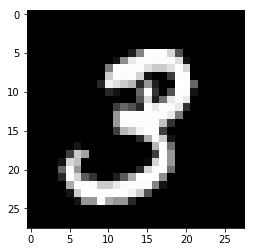

In [5]:
im = images[1].compute().reshape((28, 28))
plt.imshow(im, cmap='gray')

In [6]:
images = images.rechunk((10000, 784))
labels = labels.rechunk((10000, 10))

images = images.to_delayed().flatten().tolist()
labels = labels.to_delayed().flatten().tolist()
batches = [delayed([im, la]) for im, la in zip(images, labels)]

batches = client.compute(batches)

In [7]:
from dask_tensorflow import start_tensorflow
tf_spec, dask_spec = start_tensorflow(client,ps=1,worker=2,scorer=1)

In [8]:
dask_spec

{'ps': ['tcp://127.0.0.1:41985'],
 'scorer': ['tcp://127.0.0.1:33524'],
 'worker': ['tcp://127.0.0.1:41270', 'tcp://127.0.0.1:41200']}

In [9]:
import math
import tempfile
import time
from queue import Empty

IMAGE_PIXELS = 28
hidden_units = 100
learning_rate = 0.01
sync_replicas = False
replicas_to_aggregate = len(dask_spec['worker'])

In [10]:
def model(server):
    worker_device = "/job:%s/task:%d" % (server.server_def.job_name,
                                         server.server_def.task_index)
    task_index = server.server_def.task_index
    is_chief = task_index == 0

    with tf.device(tf.train.replica_device_setter(
                      worker_device=worker_device,
                      ps_device="/job:ps/cpu:0",
                      cluster=tf_spec)):

        global_step = tf.Variable(0, name="global_step", trainable=False)

        # Variables of the hidden layer
        hid_w = tf.Variable(
            tf.truncated_normal(
                [IMAGE_PIXELS * IMAGE_PIXELS, hidden_units],
                stddev=1.0 / IMAGE_PIXELS),
            name="hid_w")
        hid_b = tf.Variable(tf.zeros([hidden_units]), name="hid_b")

        # Variables of the softmax layer
        sm_w = tf.Variable(
            tf.truncated_normal(
                [hidden_units, 10],
                stddev=1.0 / math.sqrt(hidden_units)),
            name="sm_w")
        sm_b = tf.Variable(tf.zeros([10]), name="sm_b")

        # Ops: located on the worker specified with task_index
        x = tf.placeholder(tf.float32, [None, IMAGE_PIXELS * IMAGE_PIXELS])
        y_ = tf.placeholder(tf.float32, [None, 10])

        hid_lin = tf.nn.xw_plus_b(x, hid_w, hid_b)
        hid = tf.nn.relu(hid_lin)

        y = tf.nn.softmax(tf.nn.xw_plus_b(hid, sm_w, sm_b))
        cross_entropy = -tf.reduce_sum(y_ * tf.log(tf.clip_by_value(y, 1e-10, 1.0)))

        opt = tf.train.AdamOptimizer(learning_rate)

        if sync_replicas:
            if replicas_to_aggregate is None:
                replicas_to_aggregate = num_workers
            else:
                replicas_to_aggregate = replicas_to_aggregate

            opt = tf.train.SyncReplicasOptimizer(
                      opt,
                      replicas_to_aggregate=replicas_to_aggregate,
                      total_num_replicas=num_workers,
                      name="mnist_sync_replicas")

        train_step = opt.minimize(cross_entropy, global_step=global_step)

        if sync_replicas:
            local_init_op = opt.local_step_init_op
            if is_chief:
                local_init_op = opt.chief_init_op

            ready_for_local_init_op = opt.ready_for_local_init_op

            # Initial token and chief queue runners required by the sync_replicas mode
            chief_queue_runner = opt.get_chief_queue_runner()
            sync_init_op = opt.get_init_tokens_op()

        init_op = tf.global_variables_initializer()
        train_dir = tempfile.mkdtemp()

        if sync_replicas:
            sv = tf.train.Supervisor(
              is_chief=is_chief,
              logdir=train_dir,
              init_op=init_op,
              local_init_op=local_init_op,
              ready_for_local_init_op=ready_for_local_init_op,
              recovery_wait_secs=1,
              global_step=global_step)
        else:
            sv = tf.train.Supervisor(
              is_chief=is_chief,
              logdir=train_dir,
              init_op=init_op,
              recovery_wait_secs=1,
              global_step=global_step)

        sess_config = tf.ConfigProto(
            allow_soft_placement=True,
            log_device_placement=False,
            device_filters=["/job:ps", "/job:worker/task:%d" % task_index])

        # The chief worker (task_index==0) session will prepare the session,
        # while the remaining workers will wait for the preparation to complete.
        if is_chief:
            print("Worker %d: Initializing session..." % task_index)
        else:
            print("Worker %d: Waiting for session to be initialized..." %
                task_index)

        sess = sv.prepare_or_wait_for_session(server.target, config=sess_config)

        if sync_replicas and is_chief:
            sess.run(sync_init_op)
            sv.start_queue_runners(sess, [chief_queue_runner])

        return sess, x, y_, train_step, global_step, cross_entropy

In [11]:
def ps_task():
    with local_client() as c:
        c.worker.tensorflow_server.join()

In [12]:
def scoring_task():
    with local_client() as c:
        # Scores Channel
        scores = c.channel('scores', maxlen=10)

        # Make Model
        server = c.worker.tensorflow_server
        sess, _, _, _, _, cross_entropy = model(c.worker.tensorflow_server)

        # Testing Data
        from tensorflow.examples.tutorials.mnist import input_data
        mnist = input_data.read_data_sets('/tmp/mnist-data', one_hot=True)
        test_data = {x: mnist.validation.images,
                     y_: mnist.validation.labels}

        # Main Loop
        while True:
            score = sess.run(cross_entropy, feed_dict=test_data)
            scores.append(float(score))

            time.sleep(1)

In [13]:
def worker_task():
    with local_client() as c:
        scores = c.channel('scores')
        num_workers = replicas_to_aggregate = len(dask_spec['worker'])

        server = c.worker.tensorflow_server
        queue = c.worker.tensorflow_queue

        # Make model
        sess, x, y_, train_step, global_step, _= model(c.worker.tensorflow_server)

        # Main loop
        while not scores or scores.data[-1] > 1000:
            try:
                batch = queue.get(timeout=0.5)
            except Empty:
                continue

            train_data = {x: batch[0],
                          y_: batch[1]}

            sess.run([train_step, global_step], feed_dict=train_data)

In [14]:
ps_tasks = [client.submit(ps_task, workers=worker)
            for worker in dask_spec['ps']]

worker_tasks = [client.submit(worker_task, workers=addr, pure=False)
                for addr in dask_spec['worker']]

scorer_task = client.submit(scoring_task, workers=dask_spec['scorer'][0])

In [15]:
dask_spec

{'ps': ['tcp://127.0.0.1:41985'],
 'scorer': ['tcp://127.0.0.1:33524'],
 'worker': ['tcp://127.0.0.1:41270', 'tcp://127.0.0.1:41200']}

In [16]:
from distributed.worker_client import get_worker

def transfer_dask_to_tensorflow(batch):
    worker = get_worker()
    worker.tensorflow_queue.put(batch)

dump = client.map(transfer_dask_to_tensorflow, batches,
                  workers=dask_spec['worker'], pure=False)
